In [1]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas

In [130]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import BatchNormalization, Input, Dense, Flatten, GlobalAveragePooling2D, Conv1D,Conv2D, MaxPooling2D,MaxPooling1D, Dropout, LSTM, TimeDistributed
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [4]:
# dataset 1
df = np.load("r3m1170210s2AVI.npy")
dy = pickle.load(open('r3m1170210s2.pkl', "rb"))


In [3]:
# dataset 2
#(22796,516,388)
df = np.ndarray.astype(np.load("r4m7170321s1AVI.npy"),dtype=np.float32)
dy = np.ndarray.astype(pickle.load(open('r4m7170321s1.pkl', "rb")),dtype=np.float32)


(23000, 516, 388)


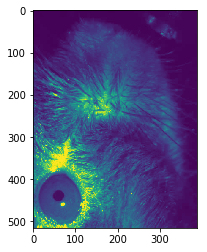

In [4]:
imc = plt.imshow((np.ndarray.astype(df[0], dtype=np.float32)))
print(df.shape)

In [5]:
#dataset1
x_data = df[33:-7280]


In [5]:
#dataset2
x_data = df[49:-226]

In [6]:
num_data         = len(x_data)
train_split      = 0.7
validation_split = 0.1
num_train        = int(train_split*num_data)
num_val          = int((num_data - num_train)*validation_split)
num_test         = num_data - num_train - num_val
x_train          = x_data[0:num_train].reshape(num_train, (516*388))
x_val            = x_data[num_train:(num_train+num_val)].reshape(num_val, (516*388))
x_test           = x_data[(num_train+num_val):].reshape(num_test, (516*388))
y_train          = dy[0:num_train].reshape(num_train, (172*130))
y_val            = dy[num_train:(num_train+num_val)].reshape(num_val, (172*130))
y_test           = dy[(num_train+num_val):].reshape(num_test, (172*130))

In [7]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [8]:
x_train_scaled.dtype

dtype('float32')

In [53]:
x_test_scaled = x_scaler.transform(x_test)
x_val_scaled  = x_scaler.transform(x_val)

In [10]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled  = y_scaler.transform(y_test)
y_val_scaled   = y_scaler.transform(y_val)

In [11]:
num_x_signals = x_train.shape[1]
print(num_x_signals)
num_y_signals = dy.shape[1]
print(num_y_signals)

200208
22360


In [12]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000001


In [13]:
x_train_scaled = np.ndarray.astype(x_train_scaled, dtype=np.float16)

In [14]:
y_train_scaled = np.ndarray.astype(y_train_scaled, dtype=np.float16)

In [15]:
# The number of pixels in each dimension of an image.
img_size_x = 516
img_size_y = 388

# The images are stored in one-dimensional arrays of this length.
img_size_flat = (516*388)

# Tuple with height and width of images used to reshape arrays.
img_shape = (516,388)

# I dont think I have this
# Number of classes, one class for each of 10 digits.
num_classes = 172*130

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

In [16]:
#TODO comeback and make this useful for my data
def plot_images(images, cls_pred=None):
    
    #Create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape(img_shape))
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

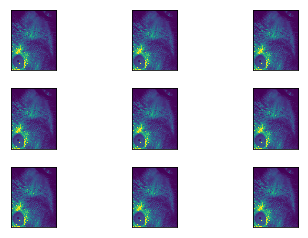

In [17]:
images = x_test[118:127]
plot_images(images=images)

In [292]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, 516, 388,1)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size,sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            if idx + sequence_length < len(x_train_scaled):
                idx = idx-((idx+sequence_length+1)-len(x_train_scaled))
            for j in range(sequence_length):
                x_batch[i][j] = np.expand_dims(x_train_scaled[idx+j].reshape(516,388), axis=3)
                y_batch[i][j] = y_train_scaled[idx+j]

        yield (x_batch, y_batch)

In [293]:
batch_size = 10
sequence_length = 5 #20 frames after stim time

In [294]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [295]:
x_batch, y_batch = next(generator)

/home/users/emccarth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [296]:
print(x_batch.shape)
print(y_batch.shape)

(10, 5, 516, 388, 1)
(10, 5, 22360)


In [297]:
x_test_scaled = np.ndarray.astype(x_test_scaled.reshape(num_test, 516, 388), np.float16)
x_val_scaled = np.ndarray.astype(x_val_scaled.reshape(num_val, 516, 388),np.float16)


In [357]:
print(len(x_val_scaled))
validation_data = (np.expand_dims(np.expand_dims(x_val_scaled,axis=3), axis=0),
                  np.expand_dims(y_val_scaled, axis=0))
print(validation_data[0].shape)

681
(1, 681, 516, 388, 1)


In [413]:
def ConvMLP(input_shape):
    X_input = Input(input_shape)
    X = TimeDistributed(Conv2D(100, (7, 7), strides = (2, 2), activation='relu', name="Conv_1a", padding="same"))(X_input)
    X = TimeDistributed(MaxPooling2D((2, 2), name = "Pool_1"))(X)
    
    X = TimeDistributed(Conv2D(32, (3, 3), name ="Conv_2a", activation='relu', padding = "same"))(X)
    X = TimeDistributed(MaxPooling2D((2, 2), name = "Pool_2"))(X)
    
    X = TimeDistributed(Conv2D(256,(3,3), name='Conv_3a'))(X)
    X = TimeDistributed(MaxPooling2D((4, 4), name = "Pool_3"))(X)

    X = TimeDistributed(Flatten())(X)
    
    X = LSTM(5, return_sequences=True)(X)
    X = Dropout(0.15)(X)
    X = Dense(num_y_signals, activation='sigmoid')(X)
    
    return Model(X_input,X)

In [387]:
# inp = Input(shape=(batch_size,sequence_length,img_size_x, img_size_y))
# base_model = Sequential()
# base_model.add(Conv2D(100,
#               kernel_size=(4,5),
#               strides=(2,2)))(inp)
# base_model.add(MaxPooling2D(pool_size=(2,2)))
# # base_model.add(Conv2D(150, (5), activation='relu'))
# # base_model.add(GlobalAveragePooling2D())
# base_model.add(Flatten())
# x = TimeDistributed(base_model)(inp)
# x = LSTM(units=5, return_sequences=True)(x)
# x = Dropout(0.15)(x)
# x = (Dense(num_y_signals, activation='sigmoid'))(x)
# model = Model(inp,x)
# # model.add(Dropout(0.15))
# # model.add(Dense(num_y_signals, activation='sigmoid'))

In [414]:
model = ConvMLP((None, img_size_x, img_size_y,1))

In [415]:
optimizer = Adam(lr=1e-3)

In [416]:
model.compile(loss='mse', optimizer=optimizer)

In [417]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, None, 516, 388, 1) 0         
_________________________________________________________________
time_distributed_216 (TimeDi (None, None, 258, 194, 10 5000      
_________________________________________________________________
time_distributed_217 (TimeDi (None, None, 129, 97, 100 0         
_________________________________________________________________
time_distributed_218 (TimeDi (None, None, 129, 97, 32) 28832     
_________________________________________________________________
time_distributed_219 (TimeDi (None, None, 64, 48, 32)  0         
_________________________________________________________________
time_distributed_220 (TimeDi (None, None, 62, 46, 256) 73984     
_________________________________________________________________
time_distributed_221 (TimeDi (None, None, 15, 11, 256) 0         
__________

In [418]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [419]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [420]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [421]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [422]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [423]:
%%time
model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/100


/home/users/emccarth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


 99/100 [============================>.] - ETA: 0s - loss: 0.0267

ResourceExhaustedError: OOM when allocating tensor with shape[681,100,258,194] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node time_distributed_216/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](time_distributed_216/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, time_distributed_216/Conv2D/ReadVariableOp)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled,axis=0),
                        y=np.expand_dims(y_test_scaled,axis=0))

In [ ]:
print(result)

In [ ]:
model.save("DRPlstmCNNds1.h5")

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled.reshape(num_train,516,388)
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled.reshape(num_test,516,388)
        y_true = y_test_scaled 
    
    # End-index for the sequences.
    end_idx = start_idx + length
    # Use the model to predict the output-signals.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
#     x = np.expand_dims(x, axis=3)
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
#     of the original data-set.
#     y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    sum_pred = []
    sum_true = []
 
    # For each output-signal.
    for i in range(len(x)):
        sum_pred.append(np.sum(y_pred[i])/(172*130))
        sum_true.append(np.sum(y_true[i])/(172*130))
    # Plot and compare the two signals.
    plt.plot(sum_true[:1200], label='true')
    plt.plot(sum_pred[:1200], label='pred')
    print("r2")
    print(r2_keras(y_true, y_pred))
    print(explained_variance_score(y_true, y_pred,multioutput='uniform_average'))
    # Plot grey box for warmup-period.


    # Plot labels etc.
    plt.ylabel("sum")
    plt.legend()
    plt.show()

In [ ]:
plot_comparison(start_idx=1, length=num_test, train=False)